In [1]:
##
## Xception проверка результативности (реализации взяты с github keras/application):
##                  https://github.com/fchollet/keras/tree/master/keras/applications
##
##
##
##
##

In [2]:
import sys,os,datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import fbeta_score
import sklearn.metrics as skm

from __future__ import print_function

In [3]:
print(np.__version__);
print(pd.__version__);

1.12.1
0.19.2


In [4]:
import  cv2 as cv
cv.__version__

'3.2.0'

In [5]:
sys.path.append('../Python')
from helper import paths_input, formImExt, formImHist
from estimate import confusion_matrix, getConfusion, getRocAUC, getProb01, getProbX01, getTh, estimateResult

In [28]:
#from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential,save_model,load_model, Model, Input
from keras.layers import Convolution2D, MaxPooling2D, Convolution1D, MaxPooling1D
from keras.layers import Activation, Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.layers import Conv2D

from keras.layers.normalization import BatchNormalization
import keras.optimizers
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint
import keras.backend as K

In [7]:
keras.__version__

'2.0.4'

In [8]:
trLabels,trDirTIF,trDirJPG,teDirTIF,teDirJPG = paths_input()
trDirI = trDirTIF
teDirI = teDirTIF
trWork, teWork = '../Work/Train', '../Work/Test'
trDirI,teDirI, teDirJPG, trWork, teWork

('../Data/train-tif-v2',
 '../Data/test-tif-v2',
 '../Data/test-jpg-v2',
 '../Work/Train',
 '../Work/Test')

In [9]:
labels_df = pd.read_csv(trLabels)
labels_df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [10]:
# Build list with unique labels
label_list = []
for tag_str in labels_df.tags.values:
    labels = tag_str.split(' ')
    for label in labels:
        if label not in label_list:
            label_list.append(label)

In [11]:
# Add onehot features for every label
for label in label_list:
    labels_df[label] = labels_df['tags'].apply(lambda x: 1 if label in x.split(' ') else 0)
    #labels_df[label].astype(np.int8)
# Display head
#labels_df.head()


In [12]:
weather_labels = ['clear', 'partly_cloudy', 'haze', 'cloudy']
land_labels = ['primary', 'agriculture', 'water', 'cultivation', 'habitation' ]
rare_labels = [l for l in label_list if labels_df[label_list].sum()[l] < 2000]
#rare_labels              

In [13]:
labels = label_list; #weather_labels;
nameList =labels_df[labels_df[labels].sum(axis=1)>0].image_name.tolist(); len(nameList)
labelList=labels_df[labels_df[labels].sum(axis=1)>0][labels].as_matrix();
labelList[:6,:]
#labels_df.head()

array([[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [96]:
del(trOX); del(trOY);

In [15]:
##np.save('../Data-Keras/Datas/train-model-2D-128x128x3-XX-not-cloudy.npy',trX)
##np.save('../Data-Keras/Datas/train-model-2D-128x128x3-YY-not-cloudy.npy',trY)

In [97]:
if False :
    ###trXX = np.load('../Data-Keras/Datas/train-model-2D-64x64x6-XX.npy')
    ###trYY = np.load('../Data-Keras/Datas/train-model-2D-64x64x6-YY.npy')
    ######trXX  = np.load('../Data-Keras/Datas/train-model-2D-64x64x3-XX.npy')
    ######trYY  = np.load('../Data-Keras/Datas/train-model-2D-64x64x3-YY.npy')
    trXX  = np.load('../Data-Keras/Datas/train-model-2D-128x128x3-XX.npy')
    trYY  = np.load('../Data-Keras/Datas/train-model-2D-128x128x3-YY.npy')
    ######trXX  = np.load('../Data-Keras/Datas/train-model-2D-224x224x3-XX.npy')
    ######trYY  = np.load('../Data-Keras/Datas/train-model-2D-224x224x3-YY.npy')

    trX, trY = trXX[trYY[:,9]==0], trYY[trYY[:,9]==0] # not cloudy == 9 feature
    trY=trY[:,range(0,9)+range(10,17)] # --cloudy <> 9
    del trXX,trYY
    #print(trXX.shape,trYY.shape)
    print(trX.shape,trY.shape)
if False :
    trX  = np.load('../Data-Keras/Datas/train-model-2D-224x224x3-XX-short.npy')
    trY  = np.load('../Data-Keras/Datas/train-model-2D-224x224x3-YY-short.npy')
    print(trX.shape,trY.shape)
if False :
    trX  = np.load('../Data-Keras/Datas/train-model-2D-128x128x3-XX-not-cloudy.npy')
    trY  = np.load('../Data-Keras/Datas/train-model-2D-128x128x3-YY-not-cloudy.npy')
    print(trX.shape,trY.shape)
    
if False :
    trX  = np.load('../Data-Keras/Datas/train-model-2D-64x64x8-XX-tif.npy')
    trY  = np.load('../Data-Keras/Datas/train-model-2D-64x64x8-YY-tif.npy')
    
if False : # VGG16-19
    trX  = np.load('../Data-Keras/Datas/train-model-2D-224x224x3-XX.npy')
    trY  = np.load('../Data-Keras/Datas/train-model-2D-224x224x3-YY.npy')
    
if False :
    trX  = np.load('../Data-Keras/Datas/train-model-2D-64x64x3-XX.npy')
    trY  = np.load('../Data-Keras/Datas/train-model-2D-64x64x3-YY.npy')
    
if False :
    trX  = np.load('../Data-Keras/Datas/train-model-2D-128x128x3-XX.npy')
    trY  = np.load('../Data-Keras/Datas/train-model-2D-128x128x3-YY.npy')
    print(trX.shape,trY.shape)
    
    
if False :
    trY  = np.load('../Data-Keras/Datas/train-model-2D-64x64x8-YY-tif.npy')
    trX0 = np.load('../Data-Keras/Datas/train-model-2D-128x128x3-XX-tif.npy')
    trX1 = np.load('../Data-Keras/Datas/train-model-2D-128x128x8-XX-tif.npy')
    #trX1 = trX1[:,:,:,3:]
    trX  = np.zeros((trX0.shape[0],trX0.shape[1],trX0.shape[2],trX0.shape[3]+trX1.shape[3]),dtype=np.uint8)
    print (trX0.shape,trX1.shape,trX.shape)
    trX[:,:,:,0:3] = trX0; del trX0
    trX[:,:,:,3:]  = trX1; del trX1
    
if False :
    trY  = np.load('../Data-Keras/Datas/train-model-2D-64x64x8-YY-tif.npy')
    trX0 = np.load('../Data-Keras/Datas/train-model-2D-64x64x3-XX-tif.npy')
    trX1 = np.load('../Data-Keras/Datas/train-model-2D-64x64x8-XX-tif.npy')
    #trX1 = trX1[:,:,:,3:]
    trX  = np.zeros((trX0.shape[0],trX0.shape[1],trX0.shape[2],trX0.shape[3]+trX1.shape[3]),dtype=np.uint8)
    print (trX0.shape,trX1.shape,trX.shape)
    trX[:,:,:,0:3] = trX0
    trX[:,:,:,3:]  = trX1
    #del trX0,trX1
    
if True :
    trX  = np.load('../Data-Keras/Datas/train-model-2D-128x128x3-XX-tif.npy').astype(np.float32)
    trY  = np.load('../Data-Keras/Datas/train-model-2D-128x128x3-YY-tif.npy')
    
    # Xception pre-processing
    
    trX  /= 255.
    trX  -= 0.5
    trX  *= 2.
    
print(trX.shape,trY.shape)

(40479, 128, 128, 3) (40479, 17)


In [98]:
#del trX0,trX1,trX

In [99]:
## Для совместной обработки tif
if False :
    trX00 = trX0.copy()
    for i in range(trX00.shape[1]) :
        for j in range(trX00.shape[2]) :
            trX00[:,i,j,:] = trX0[:,j,i,:]
    trX[:,:,:,0:3] = trX00

In [19]:
if False : # построение CCCI
    trX.shape
    ndvi_min, ndvi_max = np.zeros(trX.shape[0],dtype=np.float16), np.zeros(trX.shape[0],dtype=np.float16)
    ccci               = np.zeros((trX.shape[0],trX.shape[1],trX.shape[2]),dtype=np.uint8)
    for ii in range(trX.shape[0]) :
        ndvi_min[ii], ndvi_max[ii] = trX[ii,:,:,0].min(), trX[ii,:,:,0].max()
        ccci[ii] = (trX[ii,:,:,0]-ndvi_min[ii])/(ndvi_max[ii]-ndvi_min[ii])*256.0
    ccci.shape
    trX[:,:,:,3]=ccci
    
    ii = 50
    #plt.imshow(np.array(ccci[ii]*256.0,dtype=np.uint8),'gray'); plt.show()
    #plt.subplot(121);plt.imshow(ccci[ii],'gray'); plt.subplot(122);plt.hist(ccci[ii].ravel(),bins=50); 
    #plt.show()
    plt.subplot(121);plt.imshow(trX[ii,:,:,0],'gray'); plt.subplot(122);plt.hist(trX[ii,:,:,0].ravel(),bins=30); 
    plt.show()
    plt.subplot(121);plt.imshow(trX[ii,:,:,1],'gray'); plt.subplot(122);plt.hist(trX[ii,:,:,1].ravel(),bins=30); 
    plt.show()

In [100]:
print(trX.shape,trY.shape)
###del trX, trY

(40479, 128, 128, 3) (40479, 17)


In [21]:
if False : # Берем все
    # Берем из признаков только 4,5,6,7 - проблемные
    trY_old = trY
    trY=trY[:,4:8]
    print(trX.shape,trY.shape)

In [22]:
def fbeta_pred(y_true, y_pred, beta=2.0, OK1=0.2, eps=0.000001, printOK=False):
    beta2 = beta*beta
    yy_true = K.round(y_true)
    #yy_pred = K.round(y_pred+(0.5-OK1))
    yy_pred = K.round(y_pred)
    tp, tp_fp, fn = K.sum((yy_pred*yy_true)), K.sum(yy_true), K.sum((K.abs(yy_pred*(yy_true-1.0))))
    precision, recall = tp/(tp_fp+eps), tp/(tp+fn+eps) 
    fbeta = (1+beta2)*(precision*recall)/(beta2*precision+recall+eps)
    ##if fbeta>1.0 : fbeta = 1.0;
    if printOK :
        print('ten true ',K.get_value(yy_true))
        #print('ten pred ',y_pred)
        print('ten roun ',K.get_value(yy_pred))
        print(' pre=',K.get_value(precision),' recall=',K.get_value(recall),' tp=',
              K.get_value(tp),' fn=',K.get_value(fn),' tp+fp=',K.get_value(tp_fp))
    return(fbeta)

In [135]:
input_shape, output_classes, metric = (trX.shape[1],trX.shape[2],trX.shape[3]), trY.shape[1], 'acc'
print(input_shape,output_classes)

(128, 128, 3) 17


In [136]:
#del model11, model10
from keras.applications.xception import Xception

In [233]:
K.clear_session()

base_model = Xception(input_shape=input_shape,classes=output_classes,include_top=False,pooling=None) #,weights=None)
#model11.summary()

x = base_model.output

x = MaxPooling2D()(x)
x = Flatten()(x)
x = Dense(2048, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(2048, activation='relu')(x)
x = Dropout(0.25)(x)

# and a logistic layer -- let's say we have 200 classes
predictions = Dense(output_classes, activation='softmax')(x)

# this is the model we will train
model10 = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers :
    layer.Tranable = False

    
sgd = keras.optimizers.SGD(nesterov=True)
model10.compile(loss='binary_crossentropy', # 'mean_absolute_error'
              optimizer=sgd, #"nadam", #sgd, #"adam", #'rmsprop',
              metrics=['acc']) #['binary_accuracy']) #[fbeta_pred]) #['accuracy',fbeta_pred]) #['accuracy'])

In [234]:
model10.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 128, 128, 3)   0                                            
____________________________________________________________________________________________________
block1_conv1 (Conv2D)            (None, 63, 63, 32)    864         input_1[0][0]                    
____________________________________________________________________________________________________
block1_conv1_bn (BatchNormalizat (None, 63, 63, 32)    128         block1_conv1[0][0]               
____________________________________________________________________________________________________
block1_conv1_act (Activation)    (None, 63, 63, 32)    0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [162]:
i, layerList = 0, []
for layer in base_model.layers :
    try :
        layerList.append((i, layer.name, layer.Tranable))
    except :
        layerList.append((i, '--unknown--', True))
    i += 1;
        
if False :
    ##K.clear_session()
    for layer in base_model.layers :
        layer.Tranable = True

    sgd = keras.optimizers.SGD(nesterov=True)
    model10.compile(loss='binary_crossentropy', # 'mean_absolute_error'
              optimizer=sgd, #"nadam", #sgd, #"adam", #'rmsprop',
              metrics=['acc']) #['binary_accuracy']) #[fbeta_pred]) #['accuracy',fbeta_pred]) #['accuracy'])
    


In [182]:
#print (len(layerList), len(model11.layers))
#layerList[50:]

In [228]:
if True : 
    K.clear_session()
    model10=load_model('../Data-Keras/Models/model-Xcept-128x128x3.h5')
    
    sgd = keras.optimizers.SGD(nesterov=True,lr=0.01,decay=0.01)
    model10.compile(loss='binary_crossentropy', # 'mean_absolute_error'
              optimizer=sgd, #"nadam", #sgd, #"adam", #'rmsprop',
              metrics=['acc']) #['binary_accuracy']) #[fbeta_pred]) #['accuracy',fbeta_pred]) #['accuracy'])

In [211]:
sgd = keras.optimizers.SGD(nesterov=True,momentum=0.9,lr=0.0001)
model10.compile(loss='binary_crossentropy', # 'mean_absolute_error'
          optimizer=sgd, #"nadam", #sgd, #"adam", #'rmsprop',
          metrics=['acc']) #['binary_accuracy']) #[fbeta_pred]) #['accuracy',fbeta_pred]) #['accuracy'])

In [143]:
if False : 
    sweight  = np.zeros(trY.shape[0],dtype=np.float32);
    sweight[:]  = 1.0
    sweight[trY[:,0]==1] = 0.35
    sweight[trY[:,1]==1] = 0.25
    sweight[trY[:,2]==1] = 0.15
    sweight[trY[:,3]==1] = 0.05

In [259]:
epochs     = 12
verbose    = 2
batch_size = 32
stopping   = 4

prefixTemp = 'xc1-jpg-128x128x3'     

early_stopping = EarlyStopping(monitor='val_loss', patience=stopping,min_delta=0.0001)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=5, min_lr=0.001)

filepath="../Temp/Temp/"+prefixTemp+"-weights.{epoch:02d}-acc={"+metric+":.4f}-val_acc={val_"+metric+":.4f}-.hdf5"
##checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
#checkpoint = ModelCheckpoint(filepath, monitor='val_'+metric, verbose=1, save_best_only=True, mode='max')
checkpoint = ModelCheckpoint(filepath, monitor=metric, verbose=1, save_best_only=True, mode='max')

tr1    = np.sum([K.count_params(p) for p in set(model10.trainable_weights)])
tr2    = np.sum([K.count_params(p) for p in set(model10.non_trainable_weights)])

step = 10000
low  = 0
high = low+step

xxyy = 0
#trXX = trX #[trY[:,xxyy]==1]
#trYY = trY #[trY[:,xxyy]==1]

print(datetime.datetime.now(),tr1+tr2)
#hist1  = model10.fit(trX[low:high],trY[low:high],
#hist1  = model10.fit(trX[low:high],trY[low:high],
hist1  = model10.fit(trX,trY,
                    #sample_weight=sweight[low:high],
                    epochs=epochs, batch_size=batch_size, 
                    #initial_epoch=15,
                    validation_split=0.20, 
                    callbacks=[early_stopping,checkpoint, reduce_lr],
                    verbose=verbose)

##trP = model1.predict(trX, batch_size=128)
##fbeta2score=fbeta_score(trY, np.array(trP) > 0.2, beta=2, average='samples')
##fbeta2pred =K.get_value(fbeta_pred(trY.astype(np.float64),trP.astype(np.float64)))
print(datetime.datetime.now()) #,pp,'fbeta2s=',fbeta2score,fbeta2pred)


2017-07-14 14:02:48.662906 41871929
Train on 32383 samples, validate on 8096 samples
Epoch 1/12
Epoch 00000: acc improved from -inf to 0.85498, saving model to ../Temp/Temp/xc1-jpg-128x128x3-weights.00-acc=0.8550-val_acc=0.8508-.hdf5
648s - loss: 0.2604 - acc: 0.8550 - val_loss: 0.2613 - val_acc: 0.8508
Epoch 2/12
Epoch 00001: acc did not improve
646s - loss: 0.2593 - acc: 0.8550 - val_loss: 0.2611 - val_acc: 0.8505
Epoch 3/12
Epoch 00002: acc did not improve
645s - loss: 0.2586 - acc: 0.8549 - val_loss: 0.2608 - val_acc: 0.8515
Epoch 4/12
Epoch 00003: acc improved from 0.85498 to 0.85519, saving model to ../Temp/Temp/xc1-jpg-128x128x3-weights.03-acc=0.8552-val_acc=0.8513-.hdf5
647s - loss: 0.2576 - acc: 0.8552 - val_loss: 0.2607 - val_acc: 0.8513
Epoch 5/12
Epoch 00004: acc did not improve
645s - loss: 0.2567 - acc: 0.8551 - val_loss: 0.2605 - val_acc: 0.8522
Epoch 6/12
Epoch 00005: acc improved from 0.85519 to 0.85522, saving model to ../Temp/Temp/xc1-jpg-128x128x3-weights.05-acc=0.8

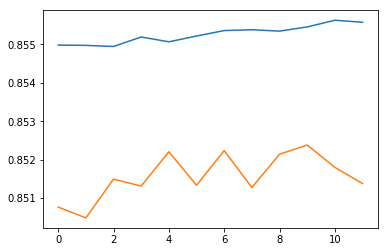

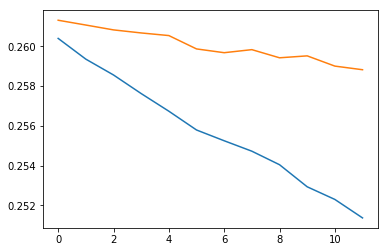

In [260]:
sgd.get_config(); hist1.history
plt.plot(hist1.history['acc']); plt.plot(hist1.history['val_acc']); plt.show()
plt.plot(hist1.history['loss']); plt.plot(hist1.history['val_loss']); plt.show()
#hist1.history

In [242]:
trX.shape, trY.shape

((40479, 128, 128, 3), (40479, 17))

In [261]:
%time trP = model10.predict(trX, batch_size=batch_size)
trP01       = getProb01(trP)
th, _       = getTh(trY,trP)
trP01x      = getProbX01(trP,th)

CPU times: user 3min, sys: 23.7 s, total: 3min 24s
Wall time: 3min 57s


In [262]:
#print(model10.evaluate(trX,trY,verbose=2,batch_size=batch_size))
print(trY.shape)
print(trP.shape)
#print('fbeta_score=',fbeta_score(trY, np.array(trP) > 0.2, beta=2, average='samples'))
#print('fbeta_score=',fbeta_score(trY, np.array(trP) > 0.5, beta=2, average='samples'))
##-------------
print('fbeta_score=',fbeta_score(trY,trP01, beta=2, average='samples'))
print('fbeta_pred =',K.get_value(fbeta_pred(trY.astype(np.float64),trP01.astype(np.float64))))
##-------------
if trY.shape[1]==17 :
    print('fbeta_score=',fbeta_score(trY,trP01x, beta=2, average='samples'))
    print('fbeta_pred =',K.get_value(fbeta_pred(trY.astype(np.float64),trP01x.astype(np.float64))))

(40479, 17)
(40479, 17)
fbeta_score= 0.220228574783
fbeta_pred = 0.421805692876
fbeta_score= 0.912607517737
fbeta_pred = 0.916018042666


In [300]:
if False :
    freeze  = ('fc1','fc2','dropout_1','dropout_2','flatten')
    trainOK = ('input_1','predictions')
    for layer in model10.layers :
        #if (layer.name=='fc1') : layer.trainable = False
        #if (layer.name=='fc2') : layer.trainable = False
        if (layer.name in freeze) : layer.trainable = False
        else : layer.trainable = True
        if (layer.name in trainOK) : layer.trainable = True
        layer.trainable = True
        print(layer.name,layer.trainable)      

In [264]:
if True :
    save_model(model10,'../Data-Keras/Models/model-Xcept1-128x128x3.h5')
    model10.save_weights('../Data-Keras/Models/model-Xcept1-128x128x3-weights.h5')
    model10.summary()
    if False : # best 0x90004
        save_model(model10,'../Work/Join-XGB-NET/VGG19-LB=0x90004/model-VGG19-128x128x3-d4096xd4096.h5')
        model10.save_weights('../Work/Join-XGB-NET/VGG19-LB=0x90004/model-VGG19-128x128x3-d4096xd4096-weights.h5')
        np.save('../Work/Join-XGB-NET/VGG19-LB=0x90004/trIP01-XX.npy',trP01)
        np.save('../Work/Join-XGB-NET/VGG19-LB=0x90004/trIP-XX.npy', trP)
        np.save('../Work/Join-XGB-NET/VGG19-LB=0x90004/trIY-YY.npy',trY)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 128, 128, 3)   0                                            
____________________________________________________________________________________________________
block1_conv1 (Conv2D)            (None, 63, 63, 32)    864         input_1[0][0]                    
____________________________________________________________________________________________________
block1_conv1_bn (BatchNormalizat (None, 63, 63, 32)    128         block1_conv1[0][0]               
____________________________________________________________________________________________________
block1_conv1_act (Activation)    (None, 63, 63, 32)    0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [82]:
model10.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 128, 128, 3)   0                                            
____________________________________________________________________________________________________
block1_conv1 (Conv2D)            (None, 63, 63, 32)    864         input_1[0][0]                    
____________________________________________________________________________________________________
block1_conv1_bn (BatchNormalizat (None, 63, 63, 32)    128         block1_conv1[0][0]               
____________________________________________________________________________________________________
block1_conv1_act (Activation)    (None, 63, 63, 32)    0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [83]:
trP[0], trY[0], trP01[0], trP01x[0]

(array([  2.24309936e-01,   5.31877398e-01,   2.64983368e-03,
          2.26821065e-01,   2.13848171e-03,   8.40854249e-04,
          1.54417346e-03,   1.46639126e-03,   4.19876334e-04,
          1.96470669e-03,   6.99866738e-04,   2.71552242e-04,
          8.72283301e-04,   2.23835188e-04,   2.69234297e-03,
          1.00432709e-03,   2.02954529e-04], dtype=float32),
 array([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.], dtype=float32),
 array([0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8))

In [139]:
# Результативность

In [263]:
temp = estimateResult(trY,trP01x,printOK=True) # 40000 jpg128 (epoch=40,features=17) Xception1

0 acc=0.97084908224 roc=0.851134301348 not=1180 yes=1923 no=37376 true=39299 all-1-0=(0.7130-0.9893)
1 acc=0.971886657279 roc=0.863427601336 not=1138 yes=37157 no=2184 true=39341 all-1-0=(0.9905-0.7363)
2 acc=0.908100496554 roc=0.890433312903 not=3720 yes=10410 no=26349 true=36759 all-1-0=(0.8453-0.9356)
3 acc=0.961585019393 roc=0.947017038946 not=1555 yes=27948 no=10976 true=38924 all-1-0=(0.9830-0.9110)
4 acc=0.928086168137 roc=0.868408240021 not=2911 yes=5738 no=31830 true=37568 all-1-0=(0.7743-0.9626)
5 acc=0.951209269004 roc=0.791215166884 not=1975 yes=2181 no=36323 true=38504 all-1-0=(0.5959-0.9865)
6 acc=0.932335284963 roc=0.884702528284 not=2739 yes=6501 no=31239 true=37740 all-1-0=(0.8055-0.9639)
7 acc=0.922774772104 roc=0.730388656838 not=3126 yes=2164 no=35189 true=37353 all-1-0=(0.4834-0.9774)
8 acc=0.994861533141 roc=0.502392344498 not=208 yes=1 no=40270 true=40271 all-1-0=(0.0048-1.0000)
9 acc=0.987079720349 roc=0.928912102504 not=523 yes=1805 no=38151 true=39956 all-1-0=

In [84]:
temp = estimateResult(trY,trP01x,printOK=True) # 40000 jpg128 (epoch=40,features=17) Xception

0 acc=0.969169198844 roc=0.833879452693 not=1248 yes=1828 no=37403 true=39231 all-1-0=(0.6778-0.9900)
1 acc=0.971936065614 roc=0.8656277377 not=1136 yes=37145 no=2198 true=39343 all-1-0=(0.9902-0.7411)
2 acc=0.904839546431 roc=0.895926668248 not=3852 yes=10753 no=25874 true=36627 all-1-0=(0.8732-0.9187)
3 acc=0.957854690086 roc=0.940798267133 not=1706 yes=27946 no=10827 true=38773 all-1-0=(0.9829-0.8987)
4 acc=0.927246226438 roc=0.854545683166 not=2945 yes=5483 no=32051 true=37534 all-1-0=(0.7398-0.9692)
5 acc=0.949060006423 roc=0.787080941816 not=2062 yes=2157 no=36260 true=38417 all-1-0=(0.5893-0.9848)
6 acc=0.929148447343 roc=0.891272309065 not=2868 yes=6685 no=30926 true=37611 all-1-0=(0.8283-0.9543)
7 acc=0.920032609501 roc=0.711146395746 not=3237 yes=1983 no=35259 true=37242 all-1-0=(0.4429-0.9794)
8 acc=0.994836828973 roc=0.511899641534 not=209 yes=5 no=40265 true=40270 all-1-0=(0.0239-0.9999)
9 acc=0.987425578695 roc=0.937015807756 not=509 yes=1840 no=38130 true=39970 all-1-0=(

In [312]:
temp = estimateResult(trY,trP01x,printOK=True) # 40000 jpg128 (epoch=40,features=17) VGG19 d4096+d4096 +weights+imnet LB=0.90004

0 acc=0.970824378073 roc=0.827535509167 not=1181 yes=1786 no=37512 true=39298 all-1-0=(0.6622-0.9929)
1 acc=0.976555744954 roc=0.877590365212 not=949 yes=37271 no=2259 true=39530 all-1-0=(0.9935-0.7616)
2 acc=0.917611601077 roc=0.909720294098 not=3335 yes=10955 no=26189 true=37144 all-1-0=(0.8896-0.9299)
3 acc=0.964376590331 roc=0.949960875432 not=1442 yes=28021 no=11016 true=39037 all-1-0=(0.9856-0.9143)
4 acc=0.937943131006 roc=0.87391779368 not=2512 yes=5728 no=32239 true=37967 all-1-0=(0.7729-0.9749)
5 acc=0.954074952444 roc=0.807677321803 not=1859 yes=2302 no=36318 true=38620 all-1-0=(0.6290-0.9864)
6 acc=0.942711035352 roc=0.901277662688 not=2319 yes=6718 no=31442 true=38160 all-1-0=(0.8324-0.9702)
7 acc=0.928012055634 roc=0.768147534975 not=2914 yes=2520 no=35045 true=37565 all-1-0=(0.5629-0.9734)
8 acc=0.994861533141 roc=0.507152201111 not=208 yes=3 no=40268 true=40271 all-1-0=(0.0144-1.0000)
9 acc=0.990464191309 roc=0.950839323708 not=386 yes=1894 no=38199 true=40093 all-1-0=(

In [50]:
#model.load_weights('../Data-Keras/train-model-2D-2-v2-loop-weights.h5') ## verify load weights from v1 version

In [265]:
# Forming output dataset for predicting --> trOX, trOY
del(trX)
del(trY)

In [266]:
trOX  = np.load('../Data-Keras/Datas/test-model-2D-128x128x3-jpg-XX.npy').astype(np.float32)
trOY  = np.load('../Data-Keras/Datas/test-model-2D-128x128x3-jpg-YY.npy')

In [267]:
# Препроцессорная обработка данных Xception

trOX  /= 255.
trOX  -= 0.5
trOX  *= 2.

In [268]:
#
#  Построение решения для test массива на основе уровней прохождения (эффект почему-то дают)
#    Построенное решение 01 полное с учетом погодных критериев [0,3,9,10]
#        и особенности критерия cloudy (посмотреть и сменить можно в getProbX01)
#        Построение критериев прохождения в getTh
#

# test
trOP = model10.predict(trOX, batch_size=batch_size)

# Уровни прохождения & решение
trO01   = getProbX01(trOP,th)


In [269]:
#trO01[0:3],np.array(th),trOP[0:3]
if False :
    np.save('../Work/Join-XGB-NET/VGG19-LB=0x90004/trO01-OX.npy',trO01)
    np.save('../Work/Join-XGB-NET/VGG19-LB=0x90004/trOP-OX.npy', trOP)
    np.save('../Work/Join-XGB-NET/VGG19-LB=0x90004/trOY-OY.npy',trOY)

In [270]:
# Строим результат

In [271]:
trZ = trO01

In [272]:
temp_list = []
for i in range(trZ.shape[0]) :
    temp = [labels[ii] for ii in range(trZ.shape[1]) if trZ[i,ii]==1];
    temp = ' '.join(temp)
    temp_list.append([trOY[i],temp])
temp_list.sort(cmp=lambda x,y: cmp(int(x[0].partition('_')[2]),int(y[0].partition('_')[2])) if (x[0].partition('_')[0]==y[0].partition('_')[0]) else cmp(y[0].partition('_')[0],x[0].partition('_')[0]))


In [274]:
temp_list[0:5]

[['test_0', 'primary clear'],
 ['test_1', 'primary clear'],
 ['test_2', 'primary partly_cloudy'],
 ['test_3', 'primary agriculture clear'],
 ['test_4', 'cloudy']]

In [275]:
rrr=pd.DataFrame(temp_list,columns=['image_name','tags']); rrr.head(); 
suffixDT = (datetime.datetime.now()).strftime('%Y-%m-%d-%H-%M-%S'); print(suffixDT)
rrr.to_csv('../Result/vss'+suffixDT+'.csv',index=False);

2017-07-14-20-15-02


In [276]:
rrr.head(10)

,image_name,tags
0,test_0,primary clear
1,test_1,primary clear
2,test_2,primary partly_cloudy
3,test_3,primary agriculture clear
4,test_4,cloudy
5,test_5,primary clear
6,test_6,primary agriculture clear habitation cultivation
7,test_7,clear habitation road
8,test_8,primary clear
9,test_9,haze primary agriculture


In [ ]:
#-------------------------------------------------------------------------------------------------------------------------------

In [ ]:
# Склад барахла

In [ ]:
Skip to content
Features Business Explore Marketplace Pricing
This repository
Search
Sign in or Sign up
 Watch 1,176  Star 17,415  Fork 6,223 fchollet/keras
 Code  Issues 1,167  Pull requests 36  Projects 1  Wiki Insights 
Branch: master Find file Copy pathkeras/keras/applications/vgg19.py
bac1637  on 22 May
@taehoonlee taehoonlee Fix typos (#6702)
4 contributors @fchollet @taehoonlee @singlas @ozancaglayan
RawBlameHistory     
193 lines (167 sloc)  8.29 KB
# -*- coding: utf-8 -*-
"""VGG19 model for Keras.
# Reference
- [Very Deep Convolutional Networks for Large-Scale Image Recognition](https://arxiv.org/abs/1409.1556)
"""
from __future__ import print_function
from __future__ import absolute_import

import warnings

from ..models import Model
from ..layers import Flatten
from ..layers import Dense
from ..layers import Input
from ..layers import Conv2D
from ..layers import MaxPooling2D
from ..layers import GlobalAveragePooling2D
from ..layers import GlobalMaxPooling2D
from ..engine.topology import get_source_inputs
from ..utils import layer_utils
from ..utils.data_utils import get_file
from .. import backend as K
from .imagenet_utils import decode_predictions
from .imagenet_utils import preprocess_input
from .imagenet_utils import _obtain_input_shape


WEIGHTS_PATH = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg19_weights_tf_dim_ordering_tf_kernels.h5'
WEIGHTS_PATH_NO_TOP = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5'


def VGG19(include_top=True, weights='imagenet',
          input_tensor=None, input_shape=None,
          pooling=None,
          classes=1000):
    """Instantiates the VGG19 architecture.
    Optionally loads weights pre-trained
    on ImageNet. Note that when using TensorFlow,
    for best performance you should set
    `image_data_format="channels_last"` in your Keras config
    at ~/.keras/keras.json.
    The model and the weights are compatible with both
    TensorFlow and Theano. The data format
    convention used by the model is the one
    specified in your Keras config file.
    # Arguments
        include_top: whether to include the 3 fully-connected
            layers at the top of the network.
        weights: one of `None` (random initialization)
            or "imagenet" (pre-training on ImageNet).
        input_tensor: optional Keras tensor (i.e. output of `layers.Input()`)
            to use as image input for the model.
        input_shape: optional shape tuple, only to be specified
            if `include_top` is False (otherwise the input shape
            has to be `(224, 224, 3)` (with `channels_last` data format)
            or `(3, 224, 224)` (with `channels_first` data format).
            It should have exactly 3 inputs channels,
            and width and height should be no smaller than 48.
            E.g. `(200, 200, 3)` would be one valid value.
        pooling: Optional pooling mode for feature extraction
            when `include_top` is `False`.
            - `None` means that the output of the model will be
                the 4D tensor output of the
                last convolutional layer.
            - `avg` means that global average pooling
                will be applied to the output of the
                last convolutional layer, and thus
                the output of the model will be a 2D tensor.
            - `max` means that global max pooling will
                be applied.
        classes: optional number of classes to classify images
            into, only to be specified if `include_top` is True, and
            if no `weights` argument is specified.
    # Returns
        A Keras model instance.
    # Raises
        ValueError: in case of invalid argument for `weights`,
            or invalid input shape.
    """
    if weights not in {'imagenet', None}:
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `imagenet` '
                         '(pre-training on ImageNet).')

    if weights == 'imagenet' and include_top and classes != 1000:
        raise ValueError('If using `weights` as imagenet with `include_top`'
                         ' as true, `classes` should be 1000')
    # Determine proper input shape
    input_shape = _obtain_input_shape(input_shape,
                                      default_size=224,
                                      min_size=48,
                                      data_format=K.image_data_format(),
                                      include_top=include_top)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor
    # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(img_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv4')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv4')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv4')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

    if include_top:
        # Classification block
        x = Flatten(name='flatten')(x)
        x = Dense(4096, activation='relu', name='fc1')(x)
        x = Dense(4096, activation='relu', name='fc2')(x)
        x = Dense(classes, activation='softmax', name='predictions')(x)
    else:
        if pooling == 'avg':
            x = GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = GlobalMaxPooling2D()(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model.
    model = Model(inputs, x, name='vgg19')

    # load weights
    if weights == 'imagenet':
        if include_top:
            weights_path = get_file('vgg19_weights_tf_dim_ordering_tf_kernels.h5',
                                    WEIGHTS_PATH,
                                    cache_subdir='models')
        else:
            weights_path = get_file('vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5',
                                    WEIGHTS_PATH_NO_TOP,
                                    cache_subdir='models')
        model.load_weights(weights_path)
        if K.backend() == 'theano':
            layer_utils.convert_all_kernels_in_model(model)

        if K.image_data_format() == 'channels_first':
            if include_top:
                maxpool = model.get_layer(name='block5_pool')
                shape = maxpool.output_shape[1:]
                dense = model.get_layer(name='fc1')
                layer_utils.convert_dense_weights_data_format(dense, shape, 'channels_first')

            if K.backend() == 'tensorflow':
                warnings.warn('You are using the TensorFlow backend, yet you '
                              'are using the Theano '
                              'image data format convention '
                              '(`image_data_format="channels_first"`). '
                              'For best performance, set '
                              '`image_data_format="channels_last"` in '
                              'your Keras config '
                              'at ~/.keras/keras.json.')
    return model
Contact GitHub API Training Shop Blog About
© 2017 GitHub, Inc. Terms Privacy Security Status Help

In [ ]:
def VGG16 ( include_top=True, weights='imagenet',
          input_tensor=None, input_shape=None,
          pooling=None,
          classes=1000):
    """Instantiates the VGG16 architecture.
    Optionally loads weights pre-trained
    on ImageNet. Note that when using TensorFlow,
    for best performance you should set
    `image_data_format="channels_last"` in your Keras config
    at ~/.keras/keras.json.
    The model and the weights are compatible with both
    TensorFlow and Theano. The data format
    convention used by the model is the one
    specified in your Keras config file.
    # Arguments
        include_top: whether to include the 3 fully-connected
            layers at the top of the network.
        weights: one of `None` (random initialization)
            or "imagenet" (pre-training on ImageNet).
        input_tensor: optional Keras tensor (i.e. output of `layers.Input()`)
            to use as image input for the model.
        input_shape: optional shape tuple, only to be specified
            if `include_top` is False (otherwise the input shape
            has to be `(224, 224, 3)` (with `channels_last` data format)
            or `(3, 224, 224)` (with `channels_first` data format).
            It should have exactly 3 inputs channels,
            and width and height should be no smaller than 48.
            E.g. `(200, 200, 3)` would be one valid value.
        pooling: Optional pooling mode for feature extraction
            when `include_top` is `False`.
            - `None` means that the output of the model will be
                the 4D tensor output of the
                last convolutional layer.
            - `avg` means that global average pooling
                will be applied to the output of the
                last convolutional layer, and thus
                the output of the model will be a 2D tensor.
            - `max` means that global max pooling will
                be applied.
        classes: optional number of classes to classify images
            into, only to be specified if `include_top` is True, and
            if no `weights` argument is specified.
    # Returns
        A Keras model instance.
    # Raises
        ValueError: in case of invalid argument for `weights`,
            or invalid input shape.
    """
    if weights not in {'imagenet', None}:
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `imagenet` '
                         '(pre-training on ImageNet).')

    if weights == 'imagenet' and include_top and classes != 1000:
        raise ValueError('If using `weights` as imagenet with `include_top`'
                         ' as true, `classes` should be 1000')
    # Determine proper input shape
    input_shape = _obtain_input_shape(input_shape,
                                      default_size=224,
                                      min_size=48,
                                      data_format=K.image_data_format(),
                                      include_top=include_top)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor    
    # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(img_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

    if include_top:
        # Classification block
        x = Flatten(name='flatten')(x)
        x = Dense(4096, activation='relu', name='fc1')(x)
        x = Dense(4096, activation='relu', name='fc2')(x)
        x = Dense(classes, activation='softmax', name='predictions')(x)
    else:
        if pooling == 'avg':
            x = GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = GlobalMaxPooling2D()(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model.
    model = Model(inputs, x, name='vgg16')

    # load weights
    if weights == 'imagenet':
        if include_top:
            weights_path = get_file('vgg16_weights_tf_dim_ordering_tf_kernels.h5',
                                    WEIGHTS_PATH,
                                    cache_subdir='models')
        else:
            weights_path = get_file('vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5',
                                    WEIGHTS_PATH_NO_TOP,
                                    cache_subdir='models')
        model.load_weights(weights_path)
        if K.backend() == 'theano':
            layer_utils.convert_all_kernels_in_model(model)

        if K.image_data_format() == 'channels_first':
            if include_top:
                maxpool = model.get_layer(name='block5_pool')
                shape = maxpool.output_shape[1:]
                dense = model.get_layer(name='fc1')
                layer_utils.convert_dense_weights_data_format(dense, shape, 'channels_first')

            if K.backend() == 'tensorflow':
                warnings.warn('You are using the TensorFlow backend, yet you '
                              'are using the Theano '
                              'image data format convention '
                              '(`image_data_format="channels_first"`). '
                              'For best performance, set '
                              '`image_data_format="channels_last"` in '
                              'your Keras config '
                              'at ~/.keras/keras.json.')
    return model


In [209]:
if False :
    from keras.utils.data_utils import get_file
    WEIGHTS_PATH = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg19_weights_tf_dim_ordering_tf_kernels.h5'
    WEIGHTS_PATH_NO_TOP = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5'


    weights_path = get_file('vgg16_weights_tf_dim_ordering_tf_kernels.h5',
                                        WEIGHTS_PATH,
                                        cache_subdir='models')


In [ ]:
weights_path = get_file('vgg19_weights_tf_dim_ordering_tf_kernels.h5',
                        WEIGHTS_PATH,
                        cache_subdir='models')
weights_path = get_file('vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        WEIGHTS_PATH_NO_TOP,
                        cache_subdir='models')

In [27]:
def buildModel (iSize,rSize,params=None,cv2d=None,dense=None) :
    model = Sequential()
    if (cv2d is None) and (dense is None) and not (params is None) : cv2d, dense = params[:-2], params[-2:]
    model = Kriz2012x3x3(model,iSize,rSize,cv2d=cv2d,dense=dense,pp=params)
    sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.99, nesterov=True)
    model.compile(loss='mean_absolute_error',  #'binary_crossentropy',
                  optimizer="adam", #sgd, #"adam", #'rmsprop',
                  metrics=[fbeta_pred,'acc']) #['binary_accuracy']) #[fbeta_pred]) #['accuracy',fbeta_pred]) #['accuracy'])
    #sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    #model.compile(loss='categorical_crossentropy',
    #              optimizer='adam', #'adam', #sgd, #"adam", #'rmsprop',
    #              metrics=['accuracy']) #[fbeta_pred]) #['accuracy',fbeta_pred]) #['accuracy'])
    return(model)

def buildModelKriz (iSize,rSize) :
    model = Sequential()
    
    model = Kriz2012(model,iSize,rSize)
    #sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.99, nesterov=True)
    sgd = keras.optimizers.SGD(nesterov=True)
    model.compile(loss='binary_crossentropy', # 'mean_absolute_error'
                  optimizer="sgd", #sgd, #"adam", #'rmsprop',
                  metrics=['acc']) #['binary_accuracy']) #[fbeta_pred]) #['accuracy',fbeta_pred]) #['accuracy'])
    #sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    #model.compile(loss='categorical_crossentropy',
    #              optimizer='adam', #'adam', #sgd, #"adam", #'rmsprop',
    #              metrics=['accuracy']) #[fbeta_pred]) #['accuracy',fbeta_pred]) #['accuracy'])
    return(model)



In [93]:
K.clear_session()

In [83]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
#from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import numpy as np

#model = VGG16(weights='imagenet', include_top=False)
model10 = VGG16(weights=None,input_shape=(224,224,3),include_top=True,classes=4)

#x = (Dense(512,activation='relu'))(model10)
#model10.add(Dropout(0.25))
#model10.add(Dense(4,activation='sigmoid'))

#img_path = 'elephant.jpg'
#img = image.load_img(img_path, target_size=(224, 224))
#x = image.img_to_array(img)
#x = np.expand_dims(x, axis=0)
#x = preprocess_input(x)

#features = model.predict(x)

In [114]:
#model10.summary()